In [3]:
import numpy as np
import torch

from data import *
from loss import *
from experiment_settings import *

## Create Data

In [4]:
training_loader, testing_loader, Us, ws, task_record = create_datasets_2(totalTasks=T, numClusters=L, perCluster=N_L, numSamples=s, baseDim=d, subDim=k, batchSize=int(s/1), sigma=20)

## Context-Free Prediction

### FTL

In [5]:
def FTL(rewards):
    """
    Input:
    rewards - numpy array of cumulative rewards indexed by experts
    Output:
    action  - task with leading cumulative reward; ties are broken by choosing an expert uniformly at random
    """
    action = np.random.choice(np.flatnonzero(rewards == rewards.max()))
    return action


### MW

In [6]:
def MWA(rewards, eta):
    """
    Input:
    rewards - list of cumulative rewards indexed by experts
    eta     - randomness hyperparameter
    Output:
    action  - sampled task from exponentially weighted distribution
    """  
    weights = np.exp(eta*rewards)
    action_cat = torch.distributions.Categorical(torch.tensor(weights/sum(weights)))
    action = int(action_cat.sample())
    return action

### Exp3

In [7]:
def Exp3(rewards):
    """
    (p.153 of Lattimore and Szepesvari) 
    Input:
    reward - observed reward at time t 
    eta     - randomness hyperparameter
    Output:
    action  - sampled task from exponentially weighted distribution
    """
    weights = np.exp(eta*rewards)
    action_cat = torch.distributions.Categorical(torch.tensor(weights/sum(weights)))
    action = int(action_cat.sample())
    return action


## Simulation

In [8]:
def context_free_sim(alg,args):
    """
    Input:
    sequence - sequence of values to predict
    alg      - algorithm used to perform online prediction
    Output:
    regret   - list of regret at every time index
    """
    rewards_actual = np.zeros(L)
    reward_cum = 0
    rewards = []
    regrets = []
    for t in range(T):
        action = alg(np.array(rewards_actual),*args)
        reward_cum += (action == task_record[t])
        rewards.append(reward_cum)
        for i in range(L):
            rewards_actual[i] += (task_record[t] == i)
        regrets.append(max(rewards_actual) - reward_cum)
    return regrets, rewards
regrets_FTL, rewards_FTL = context_free_sim(FTL,[])
regrets_MWA, rewards_MWA = context_free_sim(MWA,[1]) 

(0.0, 155.4)

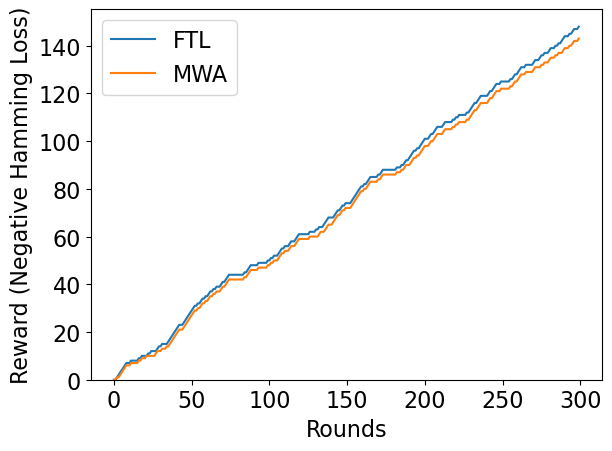

In [9]:
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 16})
all_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
_style = ['-', '--', '-.', ':', '-','--']

x_axis=np.arange(T)
y_lim = None

j4 = plt.figure(8)
plt.plot(rewards_FTL, label = "FTL")
plt.plot(rewards_MWA, label = "MWA")
plt.legend()

plt.xlabel("Rounds")
plt.ylabel("Reward (Negative Hamming Loss)")
plt.ylim(0, y_lim)

(0.0, 9.4)

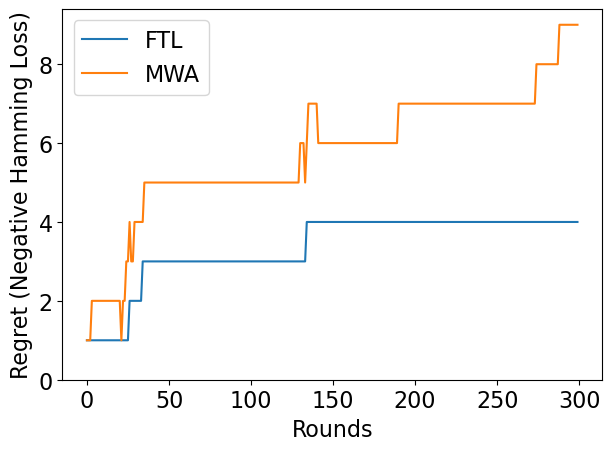

In [10]:
x_axis=np.arange(T)
y_lim = None

j4 = plt.figure(8)
plt.plot(regrets_FTL, label = "FTL")
plt.plot(regrets_MWA, label = "MWA")
plt.legend()

plt.xlabel("Rounds")
plt.ylabel("Regret (Negative Hamming Loss)")
plt.ylim(0, y_lim)

## Context-Dependent Algorithms

### Exp4

In [11]:
def Exp4(rewards,contexts):
    """
    Code that implements the Exponential weights algorithm for Exploration and Exploitation with Experts. 
    Returns index of largest reward.
    """

### Progressive Elimination

In [12]:
class ProgressiveElimination:
    def __init__(self, N, k, d, experts):
        self.N = N
        self.k = k
        self.d = d
        self.experts = experts
        self.known_subspaces = []
        self.expert_guess_matrix = np.tile(np.arange(0, N), (N, 1)).tolist()
        self.true_expert = np.zeros(N) - 1
        self.guess = []
        self.rewards = []

    def _extract_basis(self, X):
        X_centered = X - X.mean(dim=0, keepdim=True)
        cov = X_centered.T @ X_centered / (X_centered.shape[0] - 1)
        eigvals, eigvecs = torch.linalg.eigh(cov)
        return eigvecs[:, -self.k:].T

    def _match_existing_subspace(self, new_basis):
        for i, basis in enumerate(self.known_subspaces):
            combined = torch.cat([new_basis, basis], dim=0)
            if torch.linalg.matrix_rank(combined) <= self.k:
                return i
        return None

    def _eliminate_class(self, subspace_idx, wrong_class):
        if wrong_class in self.expert_guess_matrix[subspace_idx]:
            self.expert_guess_matrix[subspace_idx].remove(wrong_class)

    def _reward(self, X, y, expert_selected):
        expert = torch.from_numpy(self.experts[expert_selected]).to(torch.float32)
        expert_output = X @ expert.T
        loss = train_loss(expert_output, y)
        return 1 if loss < 1e-9 else 0

    def process(self, X_t, y_t):
        basis = self._extract_basis(X_t)
        subspace_idx = self._match_existing_subspace(basis)

        if subspace_idx is not None and self.true_expert[subspace_idx] >= 0:
            guess = int(self.true_expert[subspace_idx])
        else:
            if subspace_idx is not None:
                guess = int(np.random.choice(self.expert_guess_matrix[subspace_idx]))
            else:
                self.known_subspaces.append(basis)
                subspace_idx = len(self.known_subspaces) - 1
                guess = int(np.random.choice(self.expert_guess_matrix[subspace_idx]))

        reward = self._reward(X_t, y_t, guess)

        self.rewards.append(reward)
        self.guess.append(guess)

        if not reward:
            self._eliminate_class(subspace_idx, guess)
        else:
            self.true_expert[subspace_idx] = guess
            for idx in range(self.N):
                if guess in self.expert_guess_matrix[idx]:
                    self._eliminate_class(idx, guess)

        return subspace_idx, guess, reward

# Example run
pge = ProgressiveElimination(N=N, k=k, d=d, experts=ws)
print(f"N = {N}")
for t in range(T):
    task_training_loader = training_loader[t]
    for _, data in enumerate(task_training_loader):
        X_t, y_t = data
        idx, guess, reward = pge.process(X_t, y_t)

print(f"Number of mistakes: {T - np.sum(pge.rewards)}")

N = 2
Number of mistakes: 2


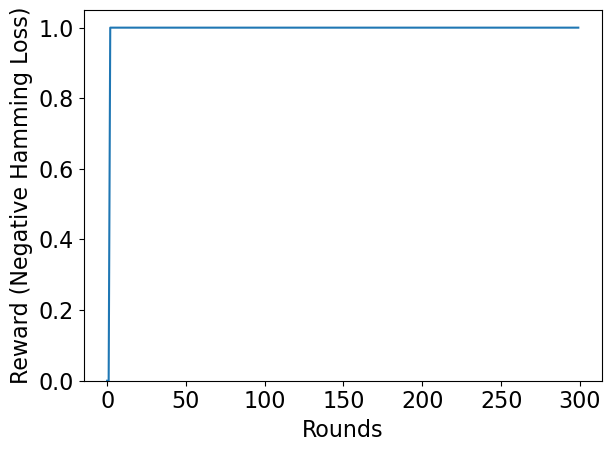

In [13]:
plt.figure(9)
plt.plot(pge.rewards)
plt.xlabel("Rounds")
plt.ylabel("Reward (Negative Hamming Loss)")
plt.ylim(0, y_lim)
plt.show()